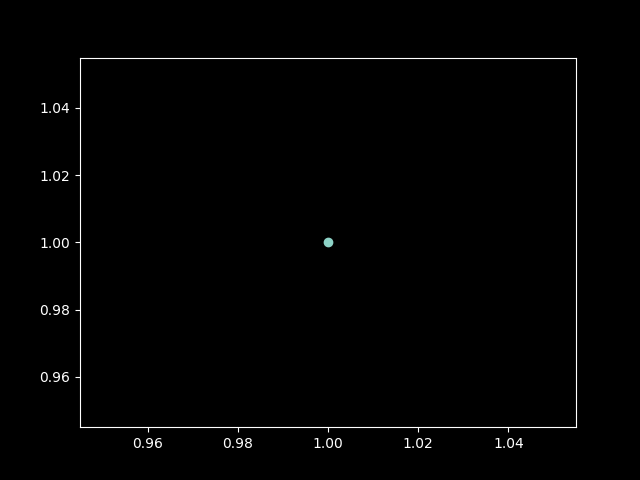

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
# from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox

plt.figure()
plt.plot(1,1,"o")
plt.show()